# 1. Create a custom gym environment

In [ ]:
from gym import Env
from gym.spaces import Discrete, Box
import os
import numpy as np
import random
import math
from enum import Enum
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [24]:
class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

In [25]:
class GameEnv(Env):
    def __init__(self, size = 10, mode='static'):
        self.mode = mode
        self.size = size
        self.GAME_LENGTH = 2 * size**2
        self.action_space = Discrete(4)
        self.observation_space = Box(low=0, high=3, shape=(self.size, self.size), dtype=np.int32)
        self.state, self.player, self.goals = self.createBoard()
        self.goals_remaining = len(self.goals)
        self.time_remaining = self.GAME_LENGTH
        self.episode = -1
        #self.make_fig_dir()
        
    def step(self, action):
        self.time_remaining -= 1
        done = False
        
        #evaluate move, save value of the new space before move then update the state
        invalid_move = False
        improved = False
        if Action(action) == Action.UP:
            new_pos = (self.player[0] -1, self.player[1])
            if new_pos[0] >= 0 and self.state[new_pos] != 1:
                new_space_val = self.evalMove(new_pos)
            else:
                invalid_move = True
        elif Action(action) == Action.DOWN:
            new_pos = (self.player[0] +1, self.player[1])
            if new_pos[0] < self.size and self.state[new_pos] != 1:
                new_space_val = self.evalMove(new_pos)
            else:
                invalid_move = True
        elif Action(action) == Action.LEFT:
            new_pos = (self.player[0], self.player[1] -1)
            if new_pos[1] >= 0 and self.state[new_pos] != 1:
                new_space_val= self.evalMove(new_pos)
            else:
                invalid_move = True
        elif Action(action) == Action.RIGHT:
            new_pos = (self.player[0], self.player[1] +1)
            if new_pos[1] < self.size and self.state[new_pos] != 1:
                new_space_val = self.evalMove(new_pos)
            else:
                invalid_move = True
        else:
            print("Invalid input to step function")
            
        #evaluate reward 
        reward = 0
        if invalid_move:
            reward = -0.5
            done = False
        else:
            if new_space_val == 0:
                reward = -0.04
                done = False
            elif new_space_val == 3:
                self.goals_remaining -= 1
                if self.goals_remaining == 0:
                    reward = 20
                    done = True
                else:
                    reward = 20
                    done = False
        
        #evaluate if out of time
        if self.time_remaining == 0:
            done = True
            reward = -20
            
        #placeholder for required return value
        info = {}
        
        return self.state, reward, done, info
    
    def distanceToGoalImproved(self, new_pos):
        distances_before = []
        distances_after = []
        for goal in self.goals:
            distances_before.append(math.sqrt((self.player[0] - goal[0])**2 + (self.player[1] - goal[1])**2))
            distances_after.append(math.sqrt((new_pos[0] - goal[0])**2 + (new_pos[1] - goal[1])**2))
        index_of_closest = distances_before.index(min(distances_before))
        distance_change = distances_after[index_of_closest] - distances_before[index_of_closest]
        if distance_change < 0:
            return True
        return False
    
    def evalMove(self, new_pos):
        new_space_val = self.state[new_pos]
        self.state[self.player] = 0
        self.state[new_pos] = 2
        self.player = new_pos
        return new_space_val
        
    def render(self, mode='human'):
        clear_output(wait=True)
        plt.figure(figsize=(5,5))
        plt.title(f'Clock: {self.time_remaining}, Goals: {self.goals_remaining}')
        plt.axis('off')
        plt.imshow(self.state)
        #if self.episode % 5 == 0:
        #    plt.savefig(f"saved_figs//ep_{self.episode}/{self.GAME_LENGTH - self.time_remaining}_step")
        plt.show()
    
    def make_fig_dir(self):
        cwd = os.getcwd()
        path = os.path.join(cwd,f"saved_figs/ep_{self.episode}")
        os.mkdir(path)

    def reset(self):
        self.state, self.player, self.goals =  self.createBoard()
        self.goals_remaining = len(self.goals)
        self.time_remaining = self.GAME_LENGTH
        self.episode += 1
        #if self.episode % 5 == 0:
        #    self.make_fig_dir()
        return self.state
    
    def createBoard(self):
        board = np.matrix([[1,1,1,1,1,1,1,1,1,1],
                           [1,0,0,0,0,0,0,0,0,1],
                           [1,1,1,0,1,1,1,0,1,1],
                           [1,0,0,0,0,1,0,0,0,1],
                           [1,0,1,1,1,1,0,1,0,1],
                           [1,0,1,1,3,1,0,1,0,1],
                           [1,0,0,0,0,0,0,1,0,1],
                           [1,1,1,0,1,0,1,1,0,1],
                           [1,3,0,0,1,0,0,0,3,1],
                           [1,1,1,1,1,1,1,1,1,1]])
        if self.mode == 'static':
            player_pos = (1,1)
            goals = [(5,5),(8,1),(8,8)]
        elif self.mode == 'random':
            player_pos = (np.random.randint(self.size), np.random.randint(self.size))
            goals = [(np.random.randint(self.size), np.random.randint(self.size))]
            player_goal_distance = math.sqrt((player_pos[0] - goals[0][0])**2 + (player_pos[1] - goals[0][1])**2)
            while player_goal_distance < self.size/2:
                goals[0] = [(np.random.randint(self.size), np.random.randint(self.size))]
                player_goal_distance = math.sqrt((player_pos[0] - goals[0][0])**2 + (player_pos[1] - goals[0][1])**2)    
        
        board[player_pos] = 2
        for coord in goals:
            if board[coord] == 0:
                board[coord] = 3
        return board, player_pos, goals

### Test

In [26]:
env = GameEnv()
episodes = 15
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    num_moves = 0
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        if reward == 20:
            print("found one")
        score += reward
        num_moves += 1
        
    print(f'Episode:{episode} Score:{score} Moves:{num_moves}')

Episode:1 Score:-75.33999999999992 Moves:200
Episode:2 Score:-72.57999999999993 Moves:200
Episode:3 Score:-76.25999999999993 Moves:200
found one
Episode:4 Score:-53.45999999999994 Moves:200
found one
Episode:5 Score:-54.83999999999994 Moves:200
Episode:6 Score:-75.79999999999993 Moves:200
found one
Episode:7 Score:-48.859999999999914 Moves:200
Episode:8 Score:-74.41999999999993 Moves:200
found one
Episode:9 Score:-58.519999999999925 Moves:200
found one
Episode:10 Score:-55.75999999999993 Moves:200
found one
Episode:11 Score:-51.159999999999926 Moves:200
found one
Episode:12 Score:-57.13999999999993 Moves:200
found one
Episode:13 Score:-52.99999999999992 Moves:200
Episode:14 Score:-68.89999999999992 Moves:200
Episode:15 Score:-84.07999999999996 Moves:200


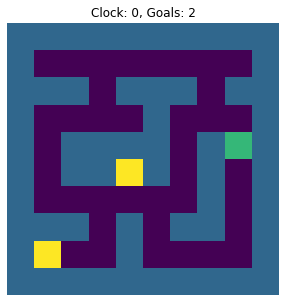

Episode:15 Score:-48.39999999999991


In [27]:
state = env.reset()
done = False
score = 0
while not done:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    score += reward
    env.render()

print(f'Episode:{episode} Score:{score}')

# 2. Create Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states[0],states[1])))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model
del env

In [ ]:
env = GameEnv()
states = env.observation_space.shape
actions = env.action_space.n
model = build_model(states,actions)

In [ ]:
model.summary()

# 3. Build Agent

In [ ]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, MaxBoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
#from tf_agents.environments import tf_py_environment

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=100000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                   nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-2)
    return dqn

In [ ]:
#env =  tf_py_environment.TFPyEnvironment(env)

dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

In [ ]:
def dqn_tester(dqn, num_eps, vis = False):
    scores = dqn.test(env, nb_episodes=num_eps, visualize=vis)
    print("Mean Reward: " + str(np.mean(scores.history['episode_reward'])))

In [ ]:
dqn_tester(dqn, 1, True)

# 4. Saving and Reloading Model

In [ ]:
dqn.save_weights('saved_models/10x10_maze_easy_redux.h5f', overwrite=False)

In [ ]:
del model
del dqn
del env

In [ ]:
env = GameEnv(size = 10)
actions = env.action_space.n
states = env.observation_space.shape
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('saved_models/50-50_success.h5f')

In [ ]:
dqn_tester(dqn, 15)

In [ ]:
dqn_tester(dqn, 1, True)